# 0. Load Modules

In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating System Interaction
import os
import sys

# Machine Learning Frameworks
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader


# Model Building and Initialization
import torch.nn as nn
from torch.nn.init import kaiming_normal_

# Data Loading and Dataset Handling
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from PIL import Image
import json

# Cross-Validation and Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score, confusion_matrix
from scipy.special import expit as sigmoid

# Visualization and Display
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import HTML
from astropy.visualization import ImageNormalize, SqrtStretch
import seaborn as sns
import sunpy.visualization.colormaps as cm

# Miscellaneous
import random
from tqdm import tqdm

# 1. Import data
- Image : 166x166
- Target : labels, boxes


In [2]:
class BoxDataset(Dataset):

    def __init__(self, data_dir, annot_file, mean=None, std=None, transforms=None):
        self.annot_file=annot_file
        self.transforms=transforms
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.mean = mean
        self.std = std
        self.classes = [_, "jet"] #class 0 is for background


    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        image_name= str(self.files[idx])
        image_name=image_name[:-4] #Getting the number of the event
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension, shape =(30,166,166)

        data = torch.from_numpy(data[15,:,:]).float()  # Convert to PyTorch tensor


        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        #Annotation file
        df=pd.read_csv(self.annot_file)
        df_im=df[df["id"]==int(image_name)]


        boxes=[]
        labels=[]

        boxes.extend(df_im[["x1","y1","x2","y2"]].values.tolist())
        boxes=torch.as_tensor(boxes,dtype=torch.float32)

        labels=torch.ones(len(boxes)).to(torch.int64) #Box only contain jet so labels are everytime one

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        #group the whole targets
        target={}
        target["boxes"]=boxes
        target["labels"]=labels
        target["image_id"]=torch.tensor([int(image_name)],dtype=torch.int64)
        target["area"]=area
        target["iscrowd"] = iscrowd

        return data, target

In [3]:
mean_data = 50.564544677734375
std_data = 49.94772720336914


folder1_path = './data/data separated/data1'

folder1_test_path = './data/data separated/data1_test'

folder1_valid_path = './data/data separated/data1_val'

label_dir='./data_boxes/tensor_boxes.pth'

In [4]:
total_dataset=BoxDataset("./data/data separated/data_jet_image", mean=mean_data, std=std_data, annot_file="./data_boxes/dataframe_pandas.csv")

{'boxes': tensor([[78.7377, 68.4058, 87.2623, 97.5942]]), 'labels': tensor([1]), 'image_id': tensor([92]), 'area': tensor([248.8210]), 'iscrowd': tensor([0])}
866


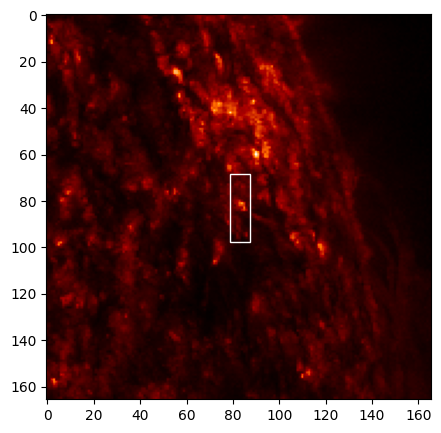

In [5]:
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img, cmap='sdoaia304')
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'w',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = total_dataset[860]

print(target)
print(len(total_dataset))
plot_img_bbox(img, target)

# 2. Create Train/Test dataset
Here we use 80% train, 20% test

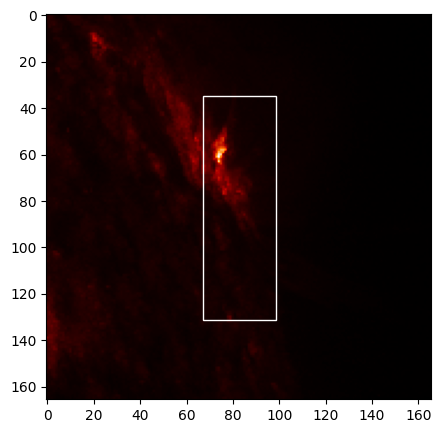

In [6]:
from utils_faster_rcnn import collate_fn
dataset = BoxDataset("./data/data separated/data_jet_image", mean=mean_data, std=std_data, annot_file="./data_boxes/dataframe_pandas.csv")
dataset_test = BoxDataset("./data/data separated/data_jet_image", mean=mean_data, std=std_data, annot_file="./data_boxes/dataframe_pandas.csv")

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

img, target=dataset[10]
plot_img_bbox(img, target)
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, collate_fn=collate_fn) #Care may be usefull to use collate_fn

# 3. Download pretrained model

In [7]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
num_classes=2 #one for jet, one for background
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features, num_classes)

# 4. Train the model

In [9]:
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [10]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [11]:
from train_eval_faster_rcnn import *

In [12]:
num_epochs=10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/70]  eta: 0:02:50  lr: 0.000015  loss: 1.2931 (1.2931)  loss_classifier: 0.2536 (0.2536)  loss_box_reg: 0.0224 (0.0224)  loss_objectness: 0.9888 (0.9888)  loss_rpn_box_reg: 0.0284 (0.0284)  time: 2.4385  data: 0.1046  max mem: 7145
Epoch: [0]  [10/70]  eta: 0:02:02  lr: 0.000160  loss: 0.7197 (0.7551)  loss_classifier: 0.3306 (0.3329)  loss_box_reg: 0.0262 (0.0299)  loss_objectness: 0.3289 (0.3634)  loss_rpn_box_reg: 0.0267 (0.0290)  time: 2.0352  data: 0.1011  max mem: 7303
Epoch: [0]  [20/70]  eta: 0:01:52  lr: 0.000305  loss: 0.5027 (0.6037)  loss_classifier: 0.1924 (0.2390)  loss_box_reg: 0.0538 (0.0551)  loss_objectness: 0.2018 (0.2808)  loss_rpn_box_reg: 0.0257 (0.0288)  time: 2.2390  data: 0.1004  max mem: 7303
Epoch: [0]  [30/70]  eta: 0:01:27  lr: 0.000450  loss: 0.4918 (0.7328)  loss_classifier: 0.1077 (0.1896)  loss_box_reg: 0.0674 (0.0531)  loss_objectness: 0.2603 (0.4502)  loss_rpn_box_reg: 0.0276 (0.0399)  time: 2.2781  data: 0.1024  max mem: 7303
Epoch: [

TypeError: object of type 'NoneType' has no len()

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to numpy array
def torch_to_pil(img):
    return img.detach().numpy()

[[78.2578937394789, 52.893236897667, 87.74210626052108, 113.10676310233302]]
tensor([1.])
465
[[55.01816479114307, 40.21723864352604, 110.98183520885692, 125.78276135647396]]
tensor([1.])
233
[[71.40398752533874, 55.89405872322454, 94.59601247466128, 110.10594127677548]]
tensor([1.])
662
[[72.84959270109611, 46.94219565333325, 93.1504072989039, 119.05780434666676]]
tensor([1.])
278
[[76.35005635671025, 64.10435327085892, 89.64994364328973, 101.89564672914106]]
tensor([1.])
797
[[77.28374860048126, 77.14349854728738, 88.71625139951874, 88.8565014527126]]
tensor([1.])
5
[[64.01157529407719, 46.697419922097815, 101.9884247059228, 119.30258007790218]]
tensor([1.])
113
[[74.76199993930565, 64.18089613418056, 91.23800006069432, 101.81910386581944]]
tensor([1.])
779
[[64.63255321118365, 50.52634318500417, 101.36744678881637, 115.47365681499582]]
tensor([1.])
4
[[77.3646514914781, 78.43573975736484, 88.6353485085219, 87.56426024263514]]
tensor([1.])
441
